# Baseline Model

## Introducción
En esta notebook se implementa un modelo base de forecasting que servirá como referencia para evaluar futuras mejoras. El modelo base nos permitirá establecer un punto de partida y medir la efectividad de técnicas más avanzadas.


## 1. Importación de Librerías

In [2]:
# Manipulación de datos
# ==============================================================================
import sys
import os
import warnings
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

# Modelado y Forecasting
# ==============================================================================
import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict

# Warnings
# ==============================================================================
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión scikit-learn: 1.5.1
Versión pandas: 2.2.2
Versión numpy: 1.26.4


c:\Users\alam_\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuración del Entorno

In [3]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)


# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [4]:
# Cargar los datos desde archivos CSV
df = pd.read_parquet(f'{data_dir}base_b_4_att.parquet')

print(df.shape)
df.head()

(59880, 8)


,product_id,city,date,sales,day_of_week,sin_day_of_week,cos_day_of_week,weekend
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-01,2.0,5,-0.974928,-0.222521,1
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-02,0.0,6,-0.781831,0.623490,1
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-03,3.0,0,0.000000,1.000000,0
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-04,2.0,1,0.781831,0.623490,0
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-05,1.0,2,0.974928,-0.222521,0


## 4. Preparación de los Datos para el Modelo Base

In [5]:
df['series_id']=df['product_id'].astype(str).str.strip() +'_'+df['city'].astype(str).str.strip()
df.head()

,product_id,city,date,sales,day_of_week,sin_day_of_week,cos_day_of_week,weekend,series_id
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-01,2.0,5,-0.974928,-0.222521,1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-02,0.0,6,-0.781831,0.623490,1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-03,3.0,0,0.000000,1.000000,0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-04,2.0,1,0.781831,0.623490,0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-05,1.0,2,0.974928,-0.222521,0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3


In [6]:

serie=df[['series_id','date','sales']].rename(columns={"series_id":"series_id","date":"timestamp","sales":"value"}).copy()
exog =df[['series_id','date','day_of_week','sin_day_of_week','weekend']].rename(columns={"series_id":"series_id","date":"timestamp"}).copy()

print(exog.shape)
exog.head()

(59880, 5)


,series_id,timestamp,day_of_week,sin_day_of_week,weekend
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-06-01,5,-0.974928,1
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-06-02,6,-0.781831,1
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-06-03,0,0.000000,0
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-06-04,1,0.781831,0
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-06-05,2,0.974928,0


In [7]:
# Transform series and exog to dictionaries
# ==============================================================================
series_dict = series_long_to_dict(
    data = serie,
    series_id = 'series_id',
    index = 'timestamp',
    values = 'value',
    freq = 'D'
)

exog_dict = exog_long_to_dict(
    data = exog,
    series_id = 'series_id',
    index = 'timestamp',
    freq = 'D'
)

In [325]:
## la serie tiene 67 dias, pero no todos los productos tienen esa edad 

## Como necesito predecir el total de una semana para los proximos 3 dias, que seria 9 dias. voy tomar como test 9 dias

## parra este caso voy utilizar tran y test, pero acostumbro dividir en 3, ya que para hacer una seleccion de los mejores hipeparametros necesito una base de tran y test, por lo tanto es mejor tener una de validacion, que tambien es conocida como fuera de muestra

serie['timestamp'].max()-serie['timestamp'].min()

Timedelta('67 days 00:00:00')

In [326]:
serie['timestamp'].max()- pd.Timedelta(days=9)

Timestamp('2024-07-29 00:00:00')

In [8]:
# Particiones de entrenamiento y test
# ==============================================================================
end_train = '2024-07-29'
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}


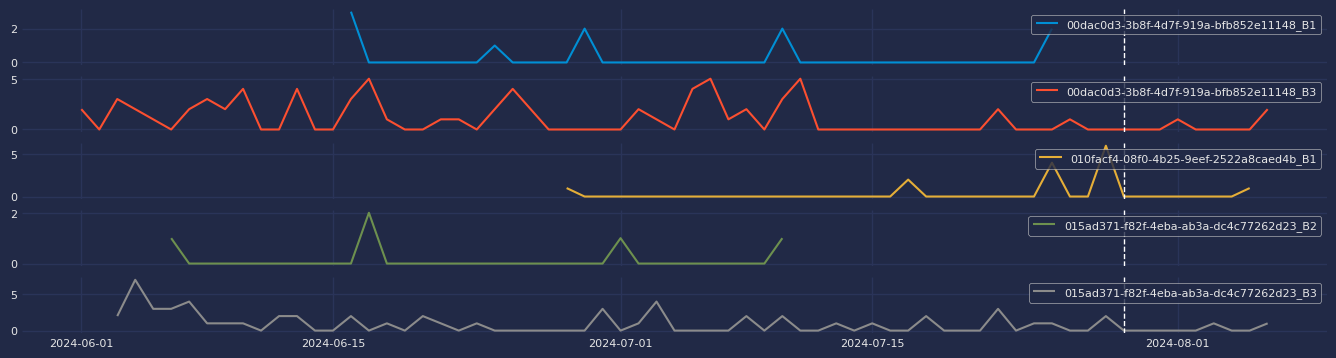

In [9]:
# como se aprecia en el grafico hay series con diferentes "edades"

set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(15, 4), sharex=True)

b=0
for i, s in enumerate(series_dict.values()):
    b +=1
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1)

    if b==5:
        break

## 4. Implementación del Modelo Base

Estuve investigando sobre series, como le comente a Carolina. no cuento con mucha experiencia en forecast. Cuento con mas experiencia en modelos de Machine lerning de clasificacion y regresion 

Suelo seguir blogs para estar al tanto de nuevs herramientas y modelos. en este caso voy a presentar una solucion que me parece mas familiar ya que el enfoque es como si fuera un modelo de machine learning 

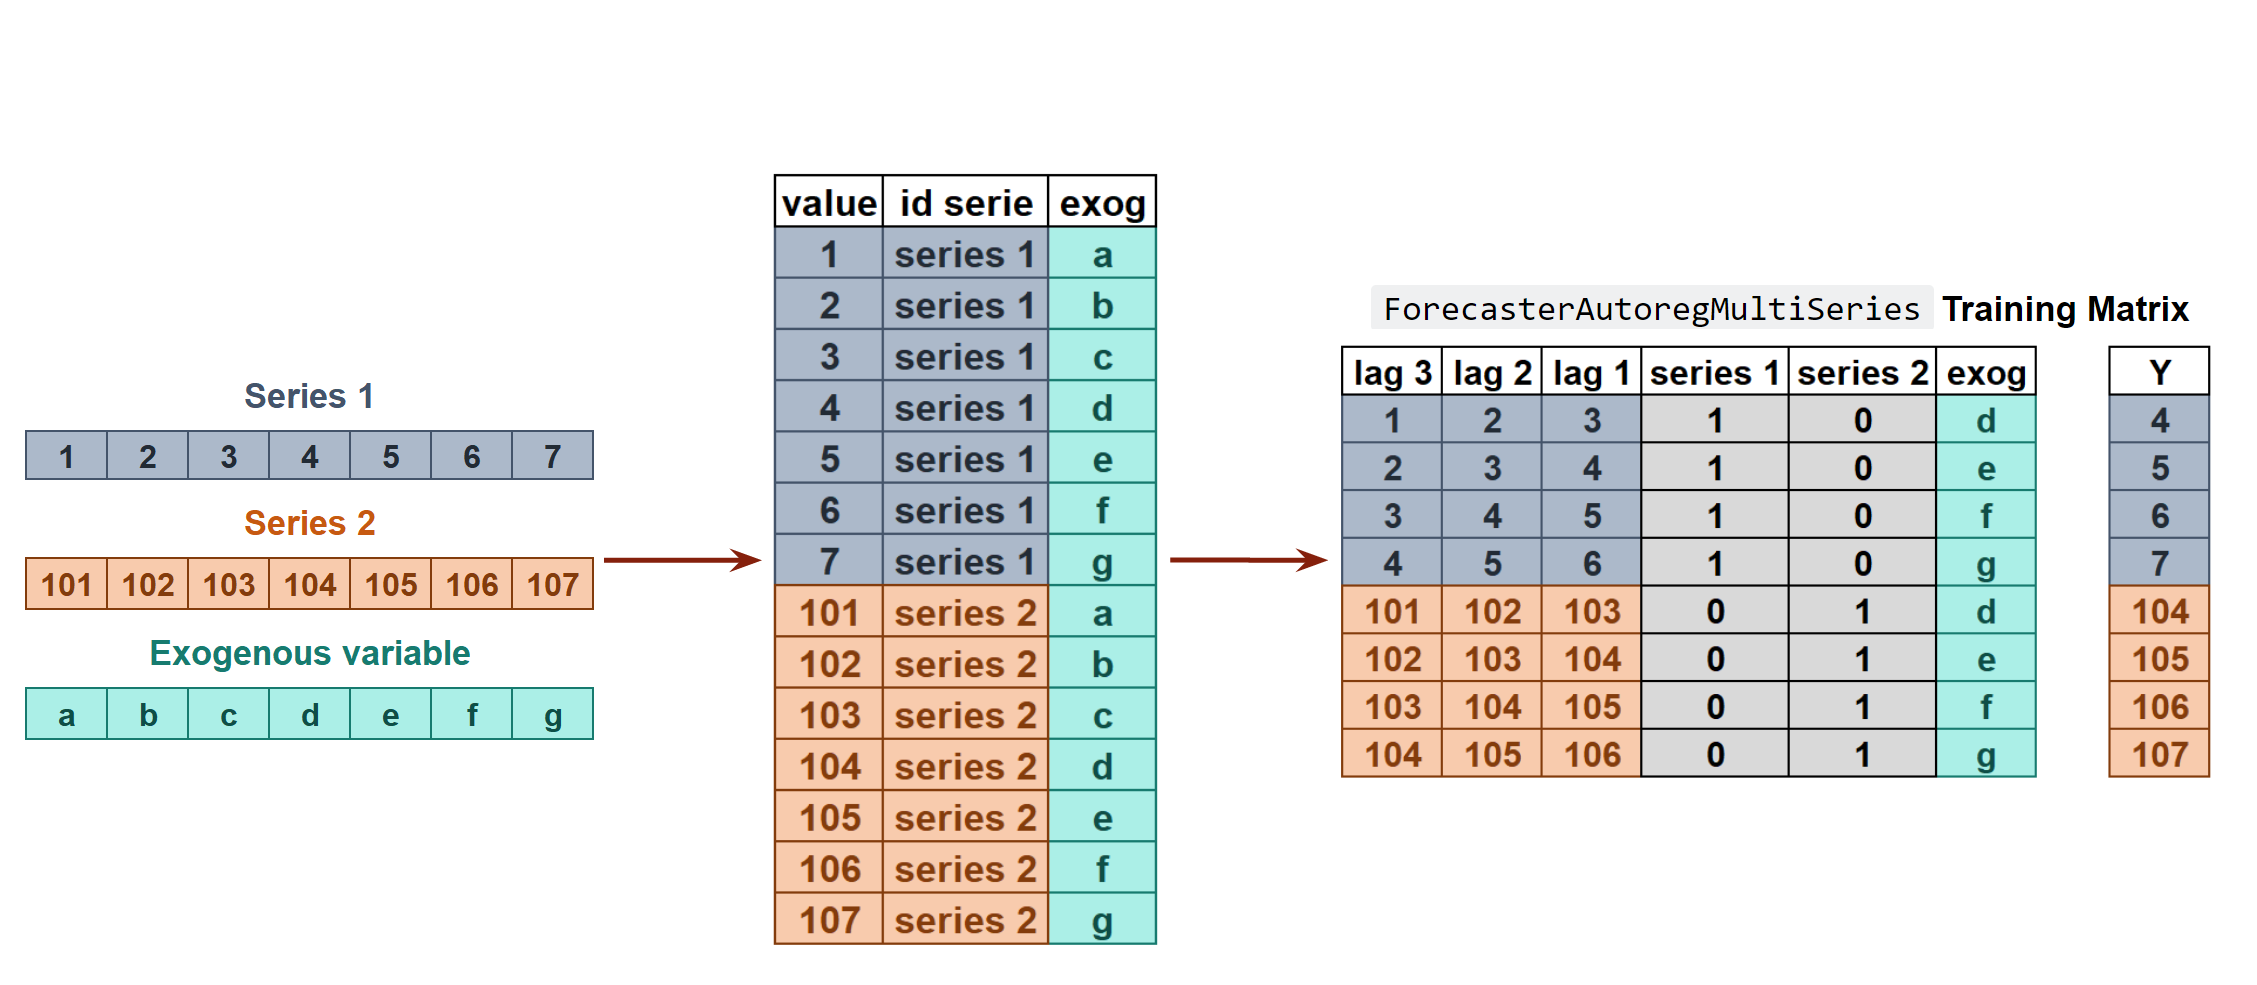

In [330]:
## primer modelo lo tomo con variables por defectos nomas para tener mi modelo base 

# ==============================================================================
regressor = HistGradientBoostingRegressor(random_state=123, max_depth=5)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 7,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(
    series = series_dict_train,
    exog   = exog_dict_train,
    suppress_warnings = True
)
forecaster

ForecasterAutoregMultiSeries 
Regressor: HistGradientBoostingRegressor(max_depth=5, random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: None 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 7 
Series levels (names): 00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1, 00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3, 010facf4-08f0-4b25-9eef-2522a8caed4b_B1, 015ad371-f82f-4eba-ab3a-dc4c77262d23_B2, 015ad371-f82f-4eba-ab3a-dc4c77262d23_B3, ... 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'dict'> 
Exogenous variables names: ['day_of_week', 'sin_day_of_week', 'weekend'] 
Training range: '00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1': ['2024-06-16', '2024-07-25'], '00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3': ['2024-06-01', '2024-07-29'], '010facf4-08f0-4b25-9eef-2522a8caed4b_B1': ['2024-06-28', '2024-07-29'], ... 
Training index type: DatetimeIndex 
Training index frequency: D 
Regresso

In [331]:
predicciones_train = forecaster.predict(steps=9, exog=exog_dict_train, suppress_warnings=True)
predicciones_train.head()


,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,010facf4-08f0-4b25-9eef-2522a8caed4b_B1,015ad371-f82f-4eba-ab3a-dc4c77262d23_B3,016910ce-27cd-4536-9b14-96e9caec3f56_B3,03506bee-8edc-4c03-b10e-4126b943a339_B3,03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3,047af93a-b988-4cfe-8af7-5d793960b295_B3,04f07f2c-ed89-4c69-9de3-e24f28032748_B1,04f07f2c-ed89-4c69-9de3-e24f28032748_B2,04f07f2c-ed89-4c69-9de3-e24f28032748_B3,0548991e-185f-497f-9c37-d7e9c51edff0_B1,0548991e-185f-497f-9c37-d7e9c51edff0_B2,0548991e-185f-497f-9c37-d7e9c51edff0_B3,0576299b-d2b9-4a95-9f65-aa74f303726a_B1,0576299b-d2b9-4a95-9f65-aa74f303726a_B2,0576299b-d2b9-4a95-9f65-aa74f303726a_B3,05d77e9c-c279-402d-b882-f2f533e0b221_B2,05d77e9c-c279-402d-b882-f2f533e0b221_B3,063a0fae-8732-42e9-ae25-aefcdffce44e_B1,063a0fae-8732-42e9-ae25-aefcdffce44e_B2,063a0fae-8732-42e9-ae25-aefcdffce44e_B3,06c3de3a-5134-4a31-8b48-9d7bd0370125_B2,06c3de3a-5134-4a31-8b48-9d7bd0370125_B3,06d507fe-e703-4a06-8efb-bd61a38990f3_B3,07078fae-2d0b-4225-99aa-587b5920a2ee_B3,07c415af-fed1-4cc4-b702-7314e1eeba4c_B3,094ecf84-9014-4900-9c53-efc209159c40_B2,094ecf84-9014-4900-9c53-efc209159c40_B3,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B1,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B3,0aa4d643-34b7-4973-85d0-b15efeff3e54_B1,0aa4d643-34b7-4973-85d0-b15efeff3e54_B2,0aa4d643-34b7-4973-85d0-b15efeff3e54_B3,0be705d4-b5df-47b9-9947-4f30ffb916ef_B1,0be705d4-b5df-47b9-9947-4f30ffb916ef_B2,0be705d4-b5df-47b9-9947-4f30ffb916ef_B3,0c72f97a-24c8-497c-b405-f4f79088b06d_B1,0c72f97a-24c8-497c-b405-f4f79088b06d_B2,0c72f97a-24c8-497c-b405-f4f79088b06d_B3,0cd34cc6-1752-4523-89a6-9852a560c41a_B1,0cd34cc6-1752-4523-89a6-9852a560c41a_B2,0cd34cc6-1752-4523-89a6-9852a560c41a_B3,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B2,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B3,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B1,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B2,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B3,0d6f6c33-a832-4136-b73b-020d7a2f3550_B3,100c5a11-9a98-4ebb-865e-7be67d2661a4_B3,11154147-50f4-4f1d-a6e2-77cc0e45d97b_B3,11844c48-064a-4e22-984f-09e58aaff9bc_B3,124a644a-8dd6-447b-bf3a-265db14fd4e6_B3,1351c284-325a-413f-bf21-b0d5e33b0355_B2,1351c284-325a-413f-bf21-b0d5e33b0355_B3,137479a2-c876-42a1-83a0-6db651b73c09_B3,14b17489-499e-46e3-a12e-caf20f1c9bed_B3,16e161b8-a6e9-44eb-bb6e-deae61d53186_B3,17887e80-fa42-4286-9c8a-d6cff4da4a00_B1,17887e80-fa42-4286-9c8a-d6cff4da4a00_B2,17887e80-fa42-4286-9c8a-d6cff4da4a00_B3,19435f74-b180-4ef0-9abd-f9598d335034_B3,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B1,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B2,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B3,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B1,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B2,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B3,1b4dec01-ac5c-48c2-a18e-7bdd868b33df_B3,1c9641b7-ba05-4b66-92f6-c04d046ab618_B1,1c9641b7-ba05-4b66-92f6-c04d046ab618_B2,1c9641b7-ba05-4b66-92f6-c04d046ab618_B3,1cdd03d0-42dd-4069-bf86-2df06f20553e_B1,1cdd03d0-42dd-4069-bf86-2df06f20553e_B3,1eef1e0a-3268-4db8-8272-44f56514d3f8_B1,1eef1e0a-3268-4db8-8272-44f56514d3f8_B2,1eef1e0a-3268-4db8-8272-44f56514d3f8_B3,209c03f2-dac6-4010-a9bb-debd2b5d0acb_B1,209c03f2-dac6-4010-a9bb-debd2b5d0acb_B2,209c03f2-dac6-4010-a9bb-debd2b5d0acb_B3,211b1fb7-e20f-4d48-acda-5c6c74a9aecd_B1,211b1fb7-e20f-4d48-acda-5c6c74a9aecd_B2,211b1fb7-e20f-4d48-acda-5c6c74a9aecd_B3,224bdb6d-e4c9-499b-a07f-cbea1ef4c2ad_B1,224bdb6d-e4c9-499b-a07f-cbea1ef4c2ad_B3,22678bd2-81ea-4bae-974f-1fd5d1d79580_B1,22678bd2-81ea-4bae-974f-1fd5d1d79580_B2,22678bd2-81ea-4bae-974f-1fd5d1d79580_B3,22e8e86a-82ef-4e90-9905-e23c83ae1cf0_B2,22e8e86a-82ef-4e90-9905-e23c83ae1cf0_B3,2381abfb-0b42-4412-ac53-39fe23c7a873_B3,24015dce-eb04-48f0-9b6c-04c08f3abd9f_B1,24015dce-eb04-48f0-9b6c-04c08f3abd9f_B3,243d9eec-32e4-472a-80ab-cb13cb08d76e_B3,24c64581-aeb1-4940-9917-b6dd91c8d8c2_B3,252abfef-7e62-45b3-b2bd-fecf603c61a5_B3,25b06ccf-3c6d-4fe8-b8e0-a66d52177bbf_B1,25b06ccf-3c6d-4fe8-b8e0-a66d52177bbf_B2,25b06ccf-3c6d-4fe8-b8e0-a66d52177bbf_B3,26055e3a-1278-45e3-95f9-fceed11b808f_B3,26973321-0148-4a3f-bbe7-efcfb94ffd11_B1

In [332]:
predicciones_test = forecaster.predict(steps=9, exog=exog_dict_test, suppress_warnings=True)
predicciones_test.head()

,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,010facf4-08f0-4b25-9eef-2522a8caed4b_B1,015ad371-f82f-4eba-ab3a-dc4c77262d23_B3,016910ce-27cd-4536-9b14-96e9caec3f56_B3,03506bee-8edc-4c03-b10e-4126b943a339_B3,03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3,047af93a-b988-4cfe-8af7-5d793960b295_B3,04f07f2c-ed89-4c69-9de3-e24f28032748_B1,04f07f2c-ed89-4c69-9de3-e24f28032748_B2,04f07f2c-ed89-4c69-9de3-e24f28032748_B3,0548991e-185f-497f-9c37-d7e9c51edff0_B1,0548991e-185f-497f-9c37-d7e9c51edff0_B2,0548991e-185f-497f-9c37-d7e9c51edff0_B3,0576299b-d2b9-4a95-9f65-aa74f303726a_B1,0576299b-d2b9-4a95-9f65-aa74f303726a_B2,0576299b-d2b9-4a95-9f65-aa74f303726a_B3,05d77e9c-c279-402d-b882-f2f533e0b221_B2,05d77e9c-c279-402d-b882-f2f533e0b221_B3,063a0fae-8732-42e9-ae25-aefcdffce44e_B1,063a0fae-8732-42e9-ae25-aefcdffce44e_B2,063a0fae-8732-42e9-ae25-aefcdffce44e_B3,06c3de3a-5134-4a31-8b48-9d7bd0370125_B2,06c3de3a-5134-4a31-8b48-9d7bd0370125_B3,06d507fe-e703-4a06-8efb-bd61a38990f3_B3,07078fae-2d0b-4225-99aa-587b5920a2ee_B3,07c415af-fed1-4cc4-b702-7314e1eeba4c_B3,094ecf84-9014-4900-9c53-efc209159c40_B2,094ecf84-9014-4900-9c53-efc209159c40_B3,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B1,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B3,0aa4d643-34b7-4973-85d0-b15efeff3e54_B1,0aa4d643-34b7-4973-85d0-b15efeff3e54_B2,0aa4d643-34b7-4973-85d0-b15efeff3e54_B3,0be705d4-b5df-47b9-9947-4f30ffb916ef_B1,0be705d4-b5df-47b9-9947-4f30ffb916ef_B2,0be705d4-b5df-47b9-9947-4f30ffb916ef_B3,0c72f97a-24c8-497c-b405-f4f79088b06d_B1,0c72f97a-24c8-497c-b405-f4f79088b06d_B2,0c72f97a-24c8-497c-b405-f4f79088b06d_B3,0cd34cc6-1752-4523-89a6-9852a560c41a_B1,0cd34cc6-1752-4523-89a6-9852a560c41a_B2,0cd34cc6-1752-4523-89a6-9852a560c41a_B3,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B2,0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B3,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B1,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B2,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B3,0d6f6c33-a832-4136-b73b-020d7a2f3550_B3,100c5a11-9a98-4ebb-865e-7be67d2661a4_B3,11154147-50f4-4f1d-a6e2-77cc0e45d97b_B3,11844c48-064a-4e22-984f-09e58aaff9bc_B3,124a644a-8dd6-447b-bf3a-265db14fd4e6_B3,1351c284-325a-413f-bf21-b0d5e33b0355_B2,1351c284-325a-413f-bf21-b0d5e33b0355_B3,137479a2-c876-42a1-83a0-6db651b73c09_B3,14b17489-499e-46e3-a12e-caf20f1c9bed_B3,16e161b8-a6e9-44eb-bb6e-deae61d53186_B3,17887e80-fa42-4286-9c8a-d6cff4da4a00_B1,17887e80-fa42-4286-9c8a-d6cff4da4a00_B2,17887e80-fa42-4286-9c8a-d6cff4da4a00_B3,19435f74-b180-4ef0-9abd-f9598d335034_B3,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B1,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B2,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B3,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B1,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B2,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B3,1b4dec01-ac5c-48c2-a18e-7bdd868b33df_B3,1c9641b7-ba05-4b66-92f6-c04d046ab618_B1,1c9641b7-ba05-4b66-92f6-c04d046ab618_B2,1c9641b7-ba05-4b66-92f6-c04d046ab618_B3,1cdd03d0-42dd-4069-bf86-2df06f20553e_B1,1cdd03d0-42dd-4069-bf86-2df06f20553e_B3,1eef1e0a-3268-4db8-8272-44f56514d3f8_B1,1eef1e0a-3268-4db8-8272-44f56514d3f8_B2,1eef1e0a-3268-4db8-8272-44f56514d3f8_B3,209c03f2-dac6-4010-a9bb-debd2b5d0acb_B1,209c03f2-dac6-4010-a9bb-debd2b5d0acb_B2,209c03f2-dac6-4010-a9bb-debd2b5d0acb_B3,211b1fb7-e20f-4d48-acda-5c6c74a9aecd_B1,211b1fb7-e20f-4d48-acda-5c6c74a9aecd_B2,211b1fb7-e20f-4d48-acda-5c6c74a9aecd_B3,224bdb6d-e4c9-499b-a07f-cbea1ef4c2ad_B1,224bdb6d-e4c9-499b-a07f-cbea1ef4c2ad_B3,22678bd2-81ea-4bae-974f-1fd5d1d79580_B1,22678bd2-81ea-4bae-974f-1fd5d1d79580_B2,22678bd2-81ea-4bae-974f-1fd5d1d79580_B3,22e8e86a-82ef-4e90-9905-e23c83ae1cf0_B2,22e8e86a-82ef-4e90-9905-e23c83ae1cf0_B3,2381abfb-0b42-4412-ac53-39fe23c7a873_B3,24015dce-eb04-48f0-9b6c-04c08f3abd9f_B1,24015dce-eb04-48f0-9b6c-04c08f3abd9f_B3,243d9eec-32e4-472a-80ab-cb13cb08d76e_B3,24c64581-aeb1-4940-9917-b6dd91c8d8c2_B3,252abfef-7e62-45b3-b2bd-fecf603c61a5_B3,25b06ccf-3c6d-4fe8-b8e0-a66d52177bbf_B1,25b06ccf-3c6d-4fe8-b8e0-a66d52177bbf_B2,25b06ccf-3c6d-4fe8-b8e0-a66d52177bbf_B3,26055e3a-1278-45e3-95f9-fceed11b808f_B3,26973321-0148-4a3f-bbe7-efcfb94ffd11_B1

In [333]:
df_pred_test=predicciones_test.melt(ignore_index=False,var_name='series_id', value_name='value_pred').reset_index(names='timestamp')
df_pred_train=predicciones_train.melt(ignore_index=False,var_name='series_id', value_name='value_pred').reset_index(names='timestamp')

df_pred_test.head(1)

,timestamp,series_id,value_pred
0,2024-07-30,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,0.496943


In [334]:
df_pre_train_=serie.merge(df_pred_train,on=['series_id','timestamp'])
df_pre_train_['error']=df_pre_train_['value']-df_pre_train_['value_pred']
df_pre_train_.head()

,series_id,timestamp,value,value_pred,error
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-07-30,0.0,0.496943,-0.496943
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-07-31,0.0,0.551044,-0.551044
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-08-01,1.0,0.795726,0.204274
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-08-02,0.0,0.849617,-0.849617
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-08-03,0.0,0.985779,-0.985779


In [335]:
df_pre_test_=serie.merge(df_pred_test,on=['series_id','timestamp'])
df_pre_test_['error']=df_pre_test_['value']-df_pre_test_['value_pred']
df_pre_test_.head()

,series_id,timestamp,value,value_pred,error
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-07-30,0.0,0.496943,-0.496943
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-07-31,0.0,0.551044,-0.551044
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-08-01,1.0,0.795726,0.204274
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-08-02,0.0,0.849617,-0.849617
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,2024-08-03,0.0,0.985779,-0.985779


In [336]:
## no ingresando mucho en detalle mirando el error promedio entre test y tran se ve una varianza . el modelo esta sobreeajustando

df_pre_test_['error'].mean(),df_pre_train_['error'].mean()

(np.float64(1.221593686419934), np.float64(1.3385366351457206))

In [337]:
## de mi experiencia modelos con profundiad baja suelen ser mas estabala y con learning_rate bajos. voy actualizar estos parametros y analizar 

# ==============================================================================
regressor = HistGradientBoostingRegressor(random_state=123, max_depth=4,learning_rate=0.01)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 7,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(
    series = series_dict_train,
    exog   = exog_dict_train,
    suppress_warnings = True
)


In [339]:
predicciones_test = forecaster.predict(steps=9, exog=exog_dict_test, suppress_warnings=True)
predicciones_train = forecaster.predict(steps=9, exog=exog_dict_train, suppress_warnings=True)


In [340]:
df_pred_train=predicciones_train.melt(ignore_index=False,var_name='series_id', value_name='value_pred').reset_index(names='timestamp')
df_pred_test=predicciones_test.melt(ignore_index=False,var_name='series_id', value_name='value_pred').reset_index(names='timestamp')

In [341]:
df_pre_train_=serie.merge(df_pred_train,on=['series_id','timestamp'])
df_pre_train_['error']=df_pre_train_['value']-df_pre_train_['value_pred']

df_pre_test_=serie.merge(df_pred_test,on=['series_id','timestamp'])
df_pre_test_['error']=df_pre_test_['value']-df_pre_test_['value_pred']

In [342]:
## aca se puede apreciar la varianza dismiuyo pero aumento el error  

df_pre_test_['error'].mean(),df_pre_train_['error'].mean()

(np.float64(1.8063692437578498), np.float64(1.7999655796351992))

### search hyperparameters

In [343]:
from skforecast.model_selection import bayesian_search_forecaster

In [345]:

selected_items = df.series_id.unique()
data = df[['series_id','date','sales']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = pd.pivot_table(
           data    = data,
           values  = 'sales',
           index   = 'date',
           columns = 'series_id'
       )
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]
data = data.asfreq('1D')
data = data.sort_index()
data.head(4)

C:\Users\alam_\AppData\Local\Temp\ipykernel_12136\347093263.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


,item_00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1,item_00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3,item_010facf4-08f0-4b25-9eef-2522a8caed4b_B1,item_015ad371-f82f-4eba-ab3a-dc4c77262d23_B2,item_015ad371-f82f-4eba-ab3a-dc4c77262d23_B3,item_016910ce-27cd-4536-9b14-96e9caec3f56_B3,item_01ceb2f7-f178-4a23-b470-20755a3be241_B3,item_03506bee-8edc-4c03-b10e-4126b943a339_B1,item_03506bee-8edc-4c03-b10e-4126b943a339_B3,item_03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3,item_04587b04-b34d-477a-8c24-1edf1f9effc7_B3,item_047af93a-b988-4cfe-8af7-5d793960b295_B3,item_04f07f2c-ed89-4c69-9de3-e24f28032748_B1,item_04f07f2c-ed89-4c69-9de3-e24f28032748_B2,item_04f07f2c-ed89-4c69-9de3-e24f28032748_B3,item_0548991e-185f-497f-9c37-d7e9c51edff0_B1,item_0548991e-185f-497f-9c37-d7e9c51edff0_B2,item_0548991e-185f-497f-9c37-d7e9c51edff0_B3,item_0576299b-d2b9-4a95-9f65-aa74f303726a_B1,item_0576299b-d2b9-4a95-9f65-aa74f303726a_B2,item_0576299b-d2b9-4a95-9f65-aa74f303726a_B3,item_05d77e9c-c279-402d-b882-f2f533e0b221_B1,item_05d77e9c-c279-402d-b882-f2f533e0b221_B2,item_05d77e9c-c279-402d-b882-f2f533e0b221_B3,item_063a0fae-8732-42e9-ae25-aefcdffce44e_B1,item_063a0fae-8732-42e9-ae25-aefcdffce44e_B2,item_063a0fae-8732-42e9-ae25-aefcdffce44e_B3,item_06c3de3a-5134-4a31-8b48-9d7bd0370125_B2,item_06c3de3a-5134-4a31-8b48-9d7bd0370125_B3,item_06d507fe-e703-4a06-8efb-bd61a38990f3_B1,item_06d507fe-e703-4a06-8efb-bd61a38990f3_B3,item_07078fae-2d0b-4225-99aa-587b5920a2ee_B3,item_07c415af-fed1-4cc4-b702-7314e1eeba4c_B3,item_094ecf84-9014-4900-9c53-efc209159c40_B1,item_094ecf84-9014-4900-9c53-efc209159c40_B2,item_094ecf84-9014-4900-9c53-efc209159c40_B3,item_0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B1,item_0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B2,item_0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B3,item_0aa4d643-34b7-4973-85d0-b15efeff3e54_B1,item_0aa4d643-34b7-4973-85d0-b15efeff3e54_B2,item_0aa4d643-34b7-4973-85d0-b15efeff3e54_B3,item_0b0c7b9a-ec28-4971-9d11-435c2db92869_B3,item_0be705d4-b5df-47b9-9947-4f30ffb916ef_B1,item_0be705d4-b5df-47b9-9947-4f30ffb916ef_B2,item_0be705d4-b5df-47b9-9947-4f30ffb916ef_B3,item_0c511b76-393d-4970-85a0-db86ea2f16fe_B1,item_0c511b76-393d-4970-85a0-db86ea2f16fe_B3,item_0c72f97a-24c8-497c-b405-f4f79088b06d_B1,item_0c72f97a-24c8-497c-b405-f4f79088b06d_B2,item_0c72f97a-24c8-497c-b405-f4f79088b06d_B3,item_0cd34cc6-1752-4523-89a6-9852a560c41a_B1,item_0cd34cc6-1752-4523-89a6-9852a560c41a_B2,item_0cd34cc6-1752-4523-89a6-9852a560c41a_B3,item_0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B1,item_0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B2,item_0cfa343e-6b4a-4895-9d0e-f917c714ccb2_B3,item_0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B1,item_0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B2,item_0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B3,item_0d6f6c33-a832-4136-b73b-020d7a2f3550_B3,item_100c5a11-9a98-4ebb-865e-7be67d2661a4_B2,item_100c5a11-9a98-4ebb-865e-7be67d2661a4_B3,item_1099141d-d4f7-4987-9b5d-43241fe58d80_B1,item_1099141d-d4f7-4987-9b5d-43241fe58d80_B2,item_1099141d-d4f7-4987-9b5d-43241fe58d80_B3,item_11154147-50f4-4f1d-a6e2-77cc0e45d97b_B3,item_11844c48-064a-4e22-984f-09e58aaff9bc_B1,item_11844c48-064a-4e22-984f-09e58aaff9bc_B3,item_11c9d841-fac0-4175-af5d-6feef5bf3838_B1,item_11c9d841-fac0-4175-af5d-6feef5bf3838_B2,item_11c9d841-fac0-4175-af5d-6feef5bf3838_B3,item_124a644a-8dd6-447b-bf3a-265db14fd4e6_B3,item_1351c284-325a-413f-bf21-b0d5e33b0355_B1,item_1351c284-325a-413f-bf21-b0d5e33b0355_B2,item_1351c284-325a-413f-bf21-b0d5e33b0355_B3,item_1354527f-78a7-4686-abb7-12d7ce15f5c4_B1,item_1354527f-78a7-4686-abb7-12d7ce15f5c4_B3,item_137479a2-c876-42a1-83a0-6db651b73c09_B3,item_14b17489-499e-46e3-a12e-caf20f1c9bed_B3,item_16e161b8-a6e9-44eb-bb6e-deae61d53186_B1,item_16e161b8-a6e9-44eb-bb6e-deae61d53186_B2,item_16e161b8-a6e9-44eb-bb6e-deae61d53186_B3,item_17887e80-fa42-4286-9c8a-d6cff4da4a00_B1,item_17887e80-fa42-4286-9c8a-d6cff4da4a00_B2,item_17887e80-fa42-4286-9c8a-d6cff4da4a00_B3,item_1829fd45-0814-42cc-a186-cfb838b67167_B1,item_1829fd45-0814-42cc-a186-cfb838b67167_B3,item_19435f74-b180-4ef0-9abd-f9598d3350

In [346]:
## como tienen diferentes logitud por modo de simplificacion vamos a imputar por 0. ya que se enteinde que no se tuvo ventas
data.fillna(0,inplace=True)

In [354]:
## se podria probar con mas parametros , pero de mi experiencia estos son unos de los mas importantes 

regressor = HistGradientBoostingRegressor(random_state=123, max_depth=4,learning_rate=0.01)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 7,
                encoding           = "ordinal",
                dropna_from_series = False
            )


def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [3, 7]),
        'max_depth'        : trial.suggest_int('max_depth', 3, 5),
        'learning_rate'    : trial.suggest_float('learning_rate', 0.001, 0.3)
    }
    
    return search_space

results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data[data.index<=end_train], #  filtrando solo dantos de entenamiento
                        levels             = None, # Si es None se seleccionan todos los niveles
                        search_space       = search_space,
                        n_trials           = 20,
                        steps              = 9,
                        metric             = 'mean_absolute_error',
                        initial_train_size = 49,
                        refit              = False,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = True 
                    )

Best trial: 18. Best value: 2.0084: 100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 3, 'learning_rate': 0.12446614433193004}
  Backtesting metric: 2.0083970558647124
  Levels: ['item_00dac0d3-3b8f-4d7f-919a-bfb852e11148_B1', 'item_00dac0d3-3b8f-4d7f-919a-bfb852e11148_B3', 'item_010facf4-08f0-4b25-9eef-2522a8caed4b_B1', 'item_015ad371-f82f-4eba-ab3a-dc4c77262d23_B2', 'item_015ad371-f82f-4eba-ab3a-dc4c77262d23_B3', 'item_016910ce-27cd-4536-9b14-96e9caec3f56_B3', 'item_01ceb2f7-f178-4a23-b470-20755a3be241_B3', 'item_03506bee-8edc-4c03-b10e-4126b943a339_B1', 'item_03506bee-8edc-4c03-b10e-4126b943a339_B3', 'item_03b56f4c-f2ec-4ee5-8341-87ef3e39a90e_B3', 'item_04587b04-b34d-477a-8c24-1edf1f9effc7_B3', 'item_047af93a-b988-4cfe-8af7-5d793960b295_B3', 'item_04f07f2c-ed89-4c69-9de3-e24f28032748_B1', 'item_04f07f2c-ed89-4c69-9de3-e24f28032748_B2', 'item_04f07f2c-ed89-4c69-9de3-e24f28032748_B3', 'item_0548991e-185f-497f-9c37-d7e9c51edff0_B1

In [355]:
# con los hiperparametros que nos dio , corremos el nuevo modelo

regressor = HistGradientBoostingRegressor(random_state=123, max_depth=3,learning_rate=0.124)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 7,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(
    series = series_dict_train,
    exog   = exog_dict_train,
    suppress_warnings = True
)

In [356]:
predicciones_test = forecaster.predict(steps=9, exog=exog_dict_test, suppress_warnings=True)
predicciones_train = forecaster.predict(steps=9, exog=exog_dict_train, suppress_warnings=True)

In [357]:
df_pred_train=predicciones_train.melt(ignore_index=False,var_name='series_id', value_name='value_pred').reset_index(names='timestamp')
df_pred_test=predicciones_test.melt(ignore_index=False,var_name='series_id', value_name='value_pred').reset_index(names='timestamp')

In [358]:
df_pre_train_=serie.merge(df_pred_train,on=['series_id','timestamp'])
df_pre_train_['error']=df_pre_train_['value']-df_pre_train_['value_pred']

df_pre_test_=serie.merge(df_pred_test,on=['series_id','timestamp'])
df_pre_test_['error']=df_pre_test_['value']-df_pre_test_['value_pred']

In [359]:
## aca se puede apreciar la varianza dismiuyo pero aumento el error  

df_pre_test_['error'].mean(),df_pre_train_['error'].mean() ## se observa que tiene una baja varianza y una mejor performance 

(np.float64(1.4146466594496345), np.float64(1.4063518846409655))

In [10]:
## hacer un backesting al modelo es clave para ver que tan establa es. voy utilizar los mismos para metros anteriores para analizar el modelo 

regressor = HistGradientBoostingRegressor(random_state=123, max_depth=3,learning_rate=0.124)

forecaster = ForecasterAutoregMultiSeries(
    regressor=regressor, lags=7, encoding="ordinal", dropna_from_series=False
)

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=series_dict,
    exog=exog_dict,
    steps=9,
    metric="mean_absolute_error",
    add_aggregated_metric=False,
    initial_train_size=49,
    #fixed_train_size=True,
    gap=0,
    allow_incomplete_fold=True,
    refit=False,
    n_jobs="auto",
    verbose=True,
    show_progress=True,
    suppress_warnings=True,
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 49
Number of observations used for backtesting: 19
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 9
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2024-06-01 00:00:00 -- 2024-07-19 00:00:00  (n=49)
    Validation: 2024-07-20 00:00:00 -- 2024-07-28 00:00:00  (n=9)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-07-29 00:00:00 -- 2024-08-06 00:00:00  (n=9)
Fold: 2
    Training:   No training in this fold
    Validation: 2024-08-07 00:00:00 -- 2024-08-07 00:00:00  (n=1)



100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


In [11]:
metrics_levels.loc[0, 'mean_absolute_error'] 

1.193895808220578

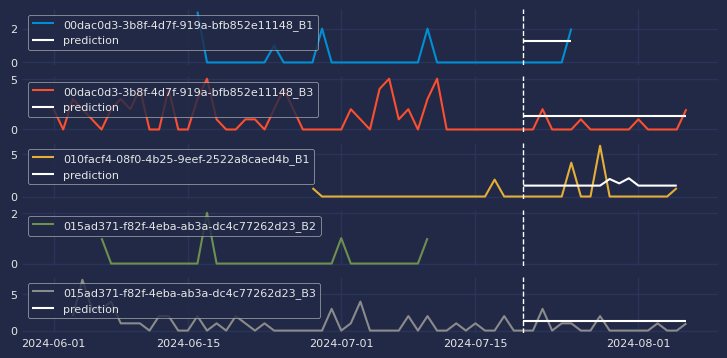

In [18]:
b=0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.keys()):
    b +=1
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    axs[i].axvline(pd.to_datetime(end_train) - pd.Timedelta(days=9), color='white', linestyle='--', linewidth=1)
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="white")
    except:
        pass
    axs[i].legend(loc='upper left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    if b==5:
        break

In [362]:
df_backtest_predictions=backtest_predictions.melt(ignore_index=False,var_name='series_id', value_name='value_pred').reset_index(names='timestamp')

In [363]:
df_backtest_predictions_=serie.merge(df_backtest_predictions,on=['series_id','timestamp'])

df_backtest_predictions_['error']=df_backtest_predictions_['value']-df_backtest_predictions_['value_pred']

## estos valores son muy similares a los del modelamiento 
df_backtest_predictions_['error'].mean()

np.float64(0.5410903766523251)

In [374]:
# ==============================================================================
regressor = HistGradientBoostingRegressor(random_state=123, max_depth=3,learning_rate=0.124)
forecaster = ForecasterAutoregMultiSeries(
                regressor          = regressor,
                lags               = 7,
                encoding           = "ordinal",
                dropna_from_series = False
            )

forecaster.fit(
    series = series_dict_train,
    exog   = exog_dict_train,
    suppress_warnings = True
)

In [375]:
## guardamos el modelo base 
import pickle

archivo_pickle = f'{models_dir}modelo_b_4_v00.pkl'

# Guardar el objeto en un archivo pickle
with open(archivo_pickle, 'wb') as archivo:
    pickle.dump(forecaster, archivo)

## 5. Modelo base Final

In [ ]:
## aca tomo el un criterio de que se quiere saber las ventas de los productos que se estaban vendiendo. tambien se podria tomar una ventana de las ultima semana de los productos vendidos y proyectar su ventas

## por lo tanto voy a filtar todos los productos que tuviern venta en el ultimo corte y proyectar su ventas 


df[df["date"]==df.date.max()].head()

In [6]:
df['series_id']=df['product_id'].astype(str).str.strip() +'_'+df['city'].astype(str).str.strip()

In [8]:
## este seria una "ETL" simplificado  

fecha_observacion = pd.to_datetime(df.date.max())  # Fecha de observación
fecha_observacion_lags=fecha_observacion-pd.Timedelta(days=7)


series_ids = df[df["date"]==fecha_observacion]['series_id'].to_list()

## la base de los ultimos lags
df_last_window=df[(df["series_id"].isin(series_ids))&
   df["date"].between(fecha_observacion_lags,fecha_observacion)][['series_id','date','sales']].rename(columns={"series_id":"series_id","date":"timestamp","sales":"value"})



# Crear un rango de fechas para los próximos 9 días a partir de la fecha de observación
fechas_prediccion = pd.date_range(start=fecha_observacion, periods=10)

# Crear un DataFrame vacío para almacenar los resultados
df_prediccion = pd.DataFrame()

# Para cada series_id, crear un DataFrame con la serie_id y las fechas
for series_id in series_ids:
    df_temp = pd.DataFrame({
        'series_id': series_id,
        'timestamp': fechas_prediccion
    })
    df_prediccion = pd.concat([df_prediccion, df_temp], ignore_index=True)

df_prediccion['day_of_week'] = df_prediccion['timestamp'].dt.dayofweek
df_prediccion['sin_day_of_week'] = np.sin(2*np.pi*df_prediccion['day_of_week']/7)
df_prediccion['weekend']=np.where(df_prediccion['day_of_week'].isin([5,6]),1,0) 


In [9]:
series_dict_pred = series_long_to_dict(
    data = df_last_window,
    series_id = 'series_id',
    index = 'timestamp',
    values = 'value',
    freq = 'D'
)

exog_dict_pred = exog_long_to_dict(
    data = df_prediccion,
    series_id = 'series_id',
    index = 'timestamp',
    freq = 'D'
)

In [ ]:
## Subimos el modelo entrenado

import pickle
archivo_pickle = f'{models_dir}modelo_b_4_v00.pkl'

# Cargar el objeto desde el archivo pickle
with open(archivo_pickle, 'rb') as archivo:
    forecaster = pickle.load(archivo)

In [377]:
forecaster.last_window=series_dict_pred

In [386]:
predicciones_pred = forecaster.predict(steps=9,
                                        exog=exog_dict_pred,
                                        suppress_warnings=True)
predicciones_pred.head()

,03506bee-8edc-4c03-b10e-4126b943a339_B3,04f07f2c-ed89-4c69-9de3-e24f28032748_B1,04f07f2c-ed89-4c69-9de3-e24f28032748_B2,04f07f2c-ed89-4c69-9de3-e24f28032748_B3,0548991e-185f-497f-9c37-d7e9c51edff0_B1,0548991e-185f-497f-9c37-d7e9c51edff0_B2,0548991e-185f-497f-9c37-d7e9c51edff0_B3,0576299b-d2b9-4a95-9f65-aa74f303726a_B1,0576299b-d2b9-4a95-9f65-aa74f303726a_B3,05d77e9c-c279-402d-b882-f2f533e0b221_B3,063a0fae-8732-42e9-ae25-aefcdffce44e_B2,063a0fae-8732-42e9-ae25-aefcdffce44e_B3,06d507fe-e703-4a06-8efb-bd61a38990f3_B3,07c415af-fed1-4cc4-b702-7314e1eeba4c_B3,094ecf84-9014-4900-9c53-efc209159c40_B3,0a6e577f-8956-4c92-ad3b-cfdd2075a5cf_B3,0aa4d643-34b7-4973-85d0-b15efeff3e54_B1,0aa4d643-34b7-4973-85d0-b15efeff3e54_B3,0cd34cc6-1752-4523-89a6-9852a560c41a_B2,0cd34cc6-1752-4523-89a6-9852a560c41a_B3,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B2,0d58ac25-37a8-4e7c-aae1-04b2a90c7fa4_B3,0d6f6c33-a832-4136-b73b-020d7a2f3550_B3,11844c48-064a-4e22-984f-09e58aaff9bc_B3,1351c284-325a-413f-bf21-b0d5e33b0355_B2,1351c284-325a-413f-bf21-b0d5e33b0355_B3,16e161b8-a6e9-44eb-bb6e-deae61d53186_B3,17887e80-fa42-4286-9c8a-d6cff4da4a00_B1,17887e80-fa42-4286-9c8a-d6cff4da4a00_B3,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B1,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B2,1b13021c-acb0-4fea-b6d4-f44d70ff3647_B3,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B1,1b4dbeb5-e4ed-4337-93e7-e9bdde3e4ae3_B3,1c9641b7-ba05-4b66-92f6-c04d046ab618_B2,1c9641b7-ba05-4b66-92f6-c04d046ab618_B3,1cdd03d0-42dd-4069-bf86-2df06f20553e_B3,1eef1e0a-3268-4db8-8272-44f56514d3f8_B1,1eef1e0a-3268-4db8-8272-44f56514d3f8_B2,1eef1e0a-3268-4db8-8272-44f56514d3f8_B3,211b1fb7-e20f-4d48-acda-5c6c74a9aecd_B3,224bdb6d-e4c9-499b-a07f-cbea1ef4c2ad_B3,22678bd2-81ea-4bae-974f-1fd5d1d79580_B3,22e8e86a-82ef-4e90-9905-e23c83ae1cf0_B3,24015dce-eb04-48f0-9b6c-04c08f3abd9f_B3,243d9eec-32e4-472a-80ab-cb13cb08d76e_B3,24c64581-aeb1-4940-9917-b6dd91c8d8c2_B3,252abfef-7e62-45b3-b2bd-fecf603c61a5_B3,25b06ccf-3c6d-4fe8-b8e0-a66d52177bbf_B1,25b06ccf-3c6d-4fe8-b8e0-a66d52177bbf_B3,26973321-0148-4a3f-bbe7-efcfb94ffd11_B3,298a045e-9a72-44ef-8ab0-44de83fd6ec7_B1,298a045e-9a72-44ef-8ab0-44de83fd6ec7_B3,29d78ad7-afb8-49cd-b162-97e5a52593ec_B3,2aac125e-5623-4206-8161-881a28d7826c_B1,2aac125e-5623-4206-8161-881a28d7826c_B3,2b6ec472-e060-43ed-b343-cc9052eb11be_B3,2b724e25-8747-4cc9-9fb0-9565fb160728_B3,2ba36bfd-c32e-4df0-8646-2520a738300f_B2,2ba36bfd-c32e-4df0-8646-2520a738300f_B3,2bfe7445-86e4-4786-8371-e9ff9f215301_B3,2c18d0cb-ad1d-4567-a492-f94beb37c475_B2,2c18d0cb-ad1d-4567-a492-f94beb37c475_B3,2c1ad666-2422-49d6-a0f5-3effa24427f4_B1,2c1ad666-2422-49d6-a0f5-3effa24427f4_B2,2c1ad666-2422-49d6-a0f5-3effa24427f4_B3,2cef4a4a-93f9-4ee3-a068-71e05488bed4_B2,2cef4a4a-93f9-4ee3-a068-71e05488bed4_B3,2e3f102b-0286-433b-b2bb-e67c04ad0c41_B3,2f3fdc1f-be68-4d24-bd63-6f435c97075e_B1,2f3fdc1f-be68-4d24-bd63-6f435c97075e_B3,2f529dfc-3f50-4d86-9168-3b3789532e80_B1,2f529dfc-3f50-4d86-9168-3b3789532e80_B2,2f529dfc-3f50-4d86-9168-3b3789532e80_B3,31aa02de-7d86-44cb-901a-e330f4cdfc8f_B2,31aa02de-7d86-44cb-901a-e330f4cdfc8f_B3,359740b7-aff4-404f-8249-a6ceb48a9a09_B3,3a8597d0-d79d-4e56-9723-07483911f5f8_B3,3b530152-fa4c-4483-9754-41b794c15ffc_B2,3b530152-fa4c-4483-9754-41b794c15ffc_B3,3cf27fbe-bece-4f34-a077-91d91b0590d8_B3,3d5f95b2-8f1d-46e9-9803-7d313188f1f8_B3,3f22a56e-3b97-45a5-9a91-0d1c99029035_B3,3ffa9e2d-689e-4612-95e9-1500300d6ac7_B1,4101c465-a6ea-469a-bf14-d89563f1932c_B1,4101c465-a6ea-469a-bf14-d89563f1932c_B3,41d05283-1790-47a9-8ec9-0758186e8517_B3,429439f8-9050-475f-b8a6-8e502391e165_B3,43ace24f-f1d5-4f9b-b99f-55ebedcb5bb7_B3,44c8dacb-812f-4c0b-bf05-7dd3fac780ee_B3,44f03ca2-46f1-441e-b108-f4c6d5b82a52_B1,45cb0157-7963-44e7-91dd-f5a172471cc0_B2,482fc0fc-5050-4dae-aa7e-973f1e6d47f3_B2,482fc0fc-5050-4dae-aa7e-973f1e6d47f3_B3,49b72647-e207-4e63-a1c1-c5fa8c549311_B2,49b72647-e207-4e63-a1c1-c5fa8c549311_B3,49c37155-4d51-4711-b4fb-b76b4f4f8f26_B1,49c37155-4d51-4711-b4fb-b76b4f4f8f26_B2,49c37155-4d51-4711-b4fb-b76b4f4f8f26_B3,4ae2289e-024f-4248-8013-202b8350b711_B1

In [409]:
predicciones_pred_=predicciones_pred.melt(ignore_index=False,var_name='series_id', value_name='sales').reset_index(names='timestamp')

predicciones_pred_.head(2)

,timestamp,series_id,sales
0,2024-08-08,03506bee-8edc-4c03-b10e-4126b943a339_B3,0.939095
1,2024-08-09,03506bee-8edc-4c03-b10e-4126b943a339_B3,0.939095


In [411]:
df_product=df[df["date"]==df.date.max()][['series_id','product_id','city']].drop_duplicates()
df_product.shape

(371, 3)

In [412]:
df_pred=df_product.merge(predicciones_pred_,on='series_id')
df_pred.shape

(3339, 5)

In [414]:
fecha_observacion_1=fecha_observacion+pd.Timedelta(days=1)
fecha_observacion_2=fecha_observacion+pd.Timedelta(days=2)
fecha_observacion_3=fecha_observacion+pd.Timedelta(days=3)
fecha_observacion_3+pd.Timedelta(days=6)

Timestamp('2024-08-16 00:00:00')

In [ ]:
## segun las metricas que vi del promedio, era positivo, eso significa que el modelo es sobreestimando

# para mitigar el riesgo de sobreestimacio voy redondear hacia abajo 

In [415]:
df_pred[df_pred['series_id']=='03506bee-8edc-4c03-b10e-4126b943a339_B3']

,series_id,product_id,city,timestamp,sales
0,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-08,0.939095
1,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-09,0.939095
2,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-10,1.028602
3,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-11,1.028602
4,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-12,1.028602
5,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-13,1.028602
6,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-14,1.028602
7,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-15,1.028602
8,03506bee-8edc-4c03-b10e-4126b943a339_B3,03506bee-8edc-4c03-b10e-4126b943a339,B3,2024-08-16,1.028602


In [416]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3339 entries, 0 to 3338
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   series_id   3339 non-null   object        
 1   product_id  3339 non-null   object        
 2   city        3339 non-null   object        
 3   timestamp   3339 non-null   datetime64[ns]
 4   sales       3339 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 130.6+ KB


In [418]:
fecha_observacion_1

Timestamp('2024-08-08 00:00:00')

In [424]:
group=['product_id','city']

df_pred['sales']=df_pred['sales'].astype(int)
df_1=df_pred[df_pred["timestamp"].between(fecha_observacion_1,fecha_observacion_1+pd.Timedelta(days=6))].groupby(group).agg(sales=('sales','sum')).reset_index()
df_1['date']=fecha_observacion_1
df_2=df_pred[df_pred["timestamp"].between(fecha_observacion_2,fecha_observacion_2+pd.Timedelta(days=6))].groupby(group).agg(sales=('sales','sum')).reset_index()
df_2['date']=fecha_observacion_2
df_3=df_pred[df_pred["timestamp"].between(fecha_observacion_3,fecha_observacion_3+pd.Timedelta(days=6))].groupby(group).agg(sales=('sales','sum')).reset_index()
df_3['date']=fecha_observacion_3


submission=pd.concat([df_1,df_2,df_3])
submission.head()

,product_id,city,sales,date
0,03506bee-8edc-4c03-b10e-4126b943a339,B3,5,2024-08-08
1,04f07f2c-ed89-4c69-9de3-e24f28032748,B1,7,2024-08-08
2,04f07f2c-ed89-4c69-9de3-e24f28032748,B2,6,2024-08-08
3,04f07f2c-ed89-4c69-9de3-e24f28032748,B3,7,2024-08-08
4,0548991e-185f-497f-9c37-d7e9c51edff0,B1,7,2024-08-08


In [425]:
submission[submission['product_id']=='03506bee-8edc-4c03-b10e-4126b943a339']


,product_id,city,sales,date
0,03506bee-8edc-4c03-b10e-4126b943a339,B3,5,2024-08-08
0,03506bee-8edc-4c03-b10e-4126b943a339,B3,6,2024-08-09
0,03506bee-8edc-4c03-b10e-4126b943a339,B3,7,2024-08-10


In [426]:
## guardar base

submission_v00 = f'{data_dir}submission_v00.csv'

submission.to_csv(submission_v00)

## 6. Conclusiones modelo base

#### Ventajas de los Modelos Multiseries

- **Facilidad de Mantenimiento:** Es más fácil mantener y controlar un único modelo en lugar de gestionar varios modelos separados.

- **Mejor Aprendizaje con Series Cortas:** Al combinar todas las series temporales en un solo entrenamiento, el modelo puede aprender mejor incluso cuando algunas series tienen pocos datos. Esto se debe a que el modelo tiene acceso a un mayor número de observaciones.

- **Patrones Más Generalizables:** Al entrenar con múltiples series temporales juntas, el modelo puede captar patrones más generales que se aplican a diferentes series.

### Desventajas de los Modelos Multiseries

- **Dinámicas Internas Diferentes:** Si las series temporales no comparten la misma dinámica interna, el modelo puede aprender un patrón que no represente bien a ninguna de ellas.

- **Enmascaramiento de Series:** Algunas series pueden ocultar a otras, lo que podría resultar en un rendimiento desigual en las predicciones para diferentes series.

- **Mayor Costo Computacional:** Entrenar y realizar backtesting en un modelo multiseries grande requiere más tiempo y recursos computacionales en comparación con entrenar varios modelos más pequeños.

### Evaluación del Modelo y Sugerencias

- **Análisis del Error:** Se puede analizar la distribución del error, observando cómo varía en función de la fecha, el producto y la ciudad.

- **Agregar Más Variables:** Considera la posibilidad de incluir variables adicionales que puedan mejorar el modelo.

- **Optimización de Hiperparámetros:** Explora otros hiperparámetros para mejorar el rendimiento del modelo.

- **Cambiar el Tipo de Modelo:** Si es necesario, prueba con diferentes tipos de modelos para ver si se obtienen mejores resultados.

### Reflexión sobre la Calidad del Modelo

Para evaluar la calidad de un modelo, es importante compararlo con lo que se tenía antes. Si ya existía un modelo anterior, mide su desempeño contra el nuevo modelo. Si no había ningún modelo previo, un buen indicador es si el nuevo modelo proporciona predicciones dentro de los parámetros esperados según la experiencia, teniendo en cuenta el tiempo disponible para desarrollarlo.



